# Model Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [2]:
mode_train = True

In [3]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [4]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [6]:
get_data_pos()
df_feat_fr = load_data_pos()

Must load more last days, 4 days missing
['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04']
2021-01-01: 474 records
2021-01-02: 475 records
2021-01-03: 474 records
2021-01-04: 476 records
1899 records downloaded
File C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel\df_meteo_fr_20210108_06_20_34.csv moved!


In [7]:
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39034  55.429856        3    141108        NaN   
2020-05-14    979  60.426966   41971  54.826499        4    142087        NaN   
2020-05-15   1021  60.042116   47665  54.380069        5    143108        NaN   
2020-05-16    291  60.158076   16523  54.488471        6    143399        NaN   
2020-05-17    139  61.568345    6603  58.292443        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2020-12-31  16015  48.586263  332662  47.453568        4   2589192   192170.0   
2021-01-01   1562  55.415493   32334  51.218346        5   2590754   176281.0   
2021-01-02  13727  46.572886  226475  48.801766        6   2604481   179385.0   
2021-01-03   2876  51.449930   45631  50.162587        0   2607357   178636.0   
2021-01-04  28648  48.073792  421912  50.712843        1   2636005   186114.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.257007  
2020-05-14       NaN  2.332563  
2020-05-15       NaN  2.142033  
2020-05-16       NaN  1.761181  
2020-05-17       NaN  2.105104  
...              ...       ...  
2020-12-31  1.148683  4.814196  
2021-01-01  1.023533  4.830828  
2021-01-02  1.017504  6.061155  
2021-01-03  1.002610  6.302733  
2021-01-04  1.018619  6.790042  

[237 rows x 15 columns]

## Retrieve old data

In [8]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [9]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39034  55.429856        3    141108        NaN   
2020-05-14    979  60.426966   41971  54.826499        4    142087        NaN   
2020-05-15   1021  60.042116   47665  54.380069        5    143108        NaN   
2020-05-16    291  60.158076   16523  54.488471        6    143399        NaN   
2020-05-17    139  61.568345    6603  58.292443        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2020-12-31  16015  48.586263  332662  47.453568        4   2589192   192170.0   
2021-01-01   1562  55.415493   32334  51.218346        5   2590754   176281.0   
2021-01-02  13727  46.572886  226475  48.801766        6   2604481   179385.0   
2021-01-03   2876  51.449930   45631  50.162587        0   2607357   178636.0   
2021-01-04  28648  48.073792  421912  50.712843        1   2636005   186114.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.257007  
2020-05-14       NaN  2.332563  
2020-05-15       NaN  2.142033  
2020-05-16       NaN  1.761181  
2020-05-17       NaN  2.105104  
...              ...       ...  
2020-12-31  1.148683  4.814196  
2021-01-01  1.023533  4.830828  
2021-01-02  1.017504  6.061155  
2021-01-03  1.002610  6.302733  
2021-01-04  1.018619  6.790042  

[237 rows x 15 columns]

In [10]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 223


In [11]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39034  55.429856        3    141108        NaN   
2020-05-14    979  60.426966   41971  54.826499        4    142087        NaN   
2020-05-15   1021  60.042116   47665  54.380069        5    143108        NaN   
2020-05-16    291  60.158076   16523  54.488471        6    143399        NaN   
2020-05-17    139  61.568345    6603  58.292443        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2020-12-31  16015  48.586263  332662  47.453568        4   2589192   192170.0   
2021-01-01   1562  55.415493   32334  51.218346        5   2590754   176281.0   
2021-01-02  13727  46.572886  226475  48.801766        6   2604481   179385.0   
2021-01-03   2876  51.449930   45631  50.162587        0   2607357   178636.0   
2021-01-04  28648  48.073792  421912  50.712843        1   2636005   186114.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.257007   True  
2020-05-14       NaN  2.332563   True  
2020-05-15       NaN  2.142033   True  
2020-05-16       NaN  1.761181   True  
2020-05-17       NaN  2.105104   True  
...              ...       ...    ...  
2020-12-31  1.148683  4.814196  False  
2021-01-01  1.023533  4.830828  False  
2021-01-02  1.017504  6.061155  False  
2021-01-03  1.002610  6.302733  False  
2021-01-04  1.018619  6.790042  False  

[237 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

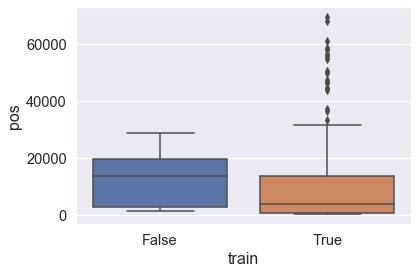

In [12]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

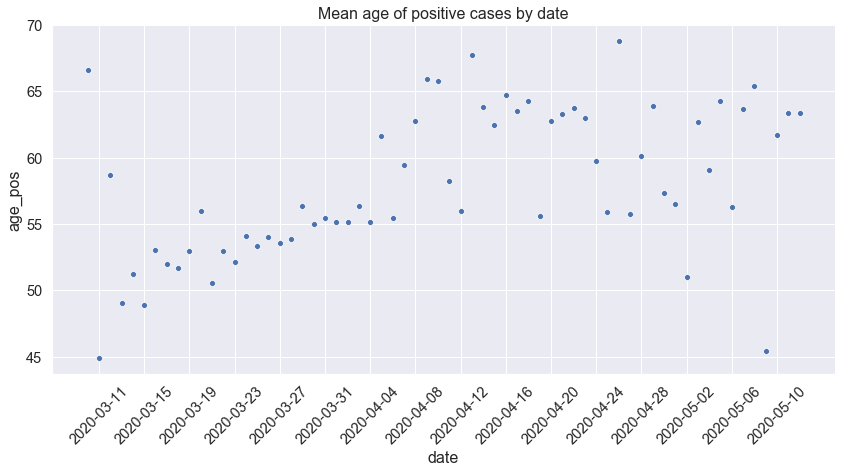

In [13]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

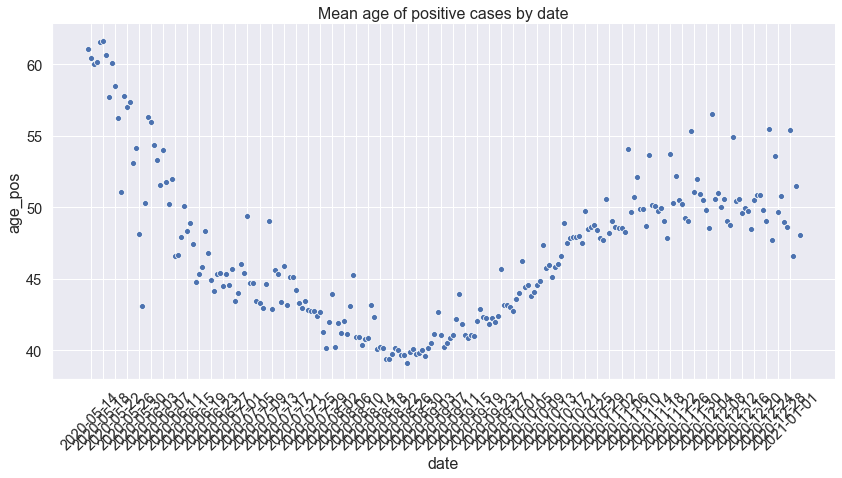

In [14]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

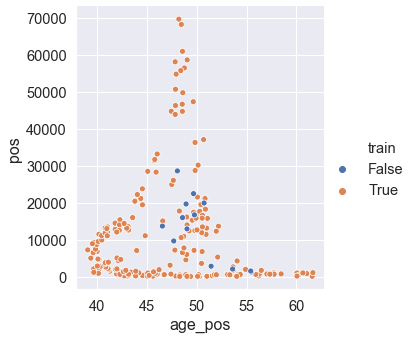

In [15]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

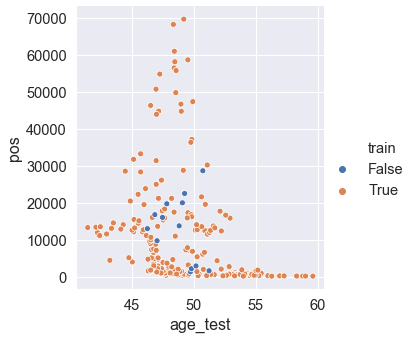

In [16]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

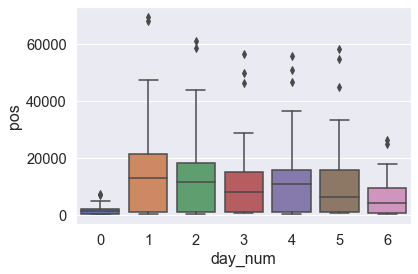

In [17]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [18]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

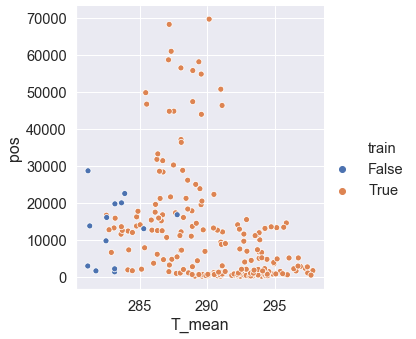

In [19]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

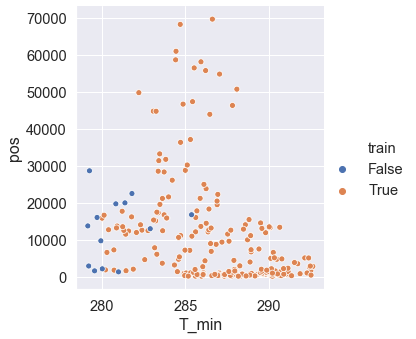

In [20]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

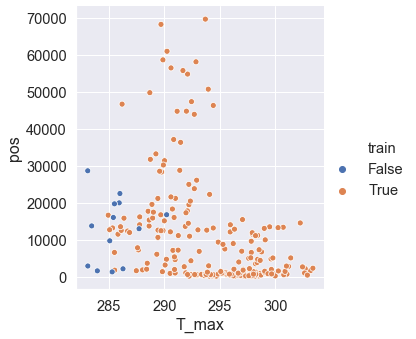

In [21]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

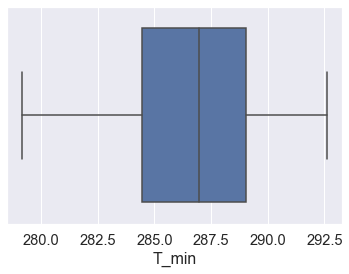

In [22]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [23]:
df_feat_fr["T_min"].mean()

286.6040338631314

In [24]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    126
True     111
Name: T_min, dtype: int64

In [25]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    119
True     118
Name: T_min, dtype: int64

In [26]:
df_feat_fr["T_min"].median()

286.94661016949163

In [27]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

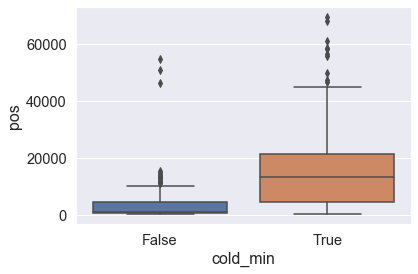

In [28]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

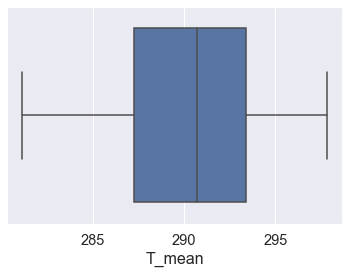

In [29]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [30]:
df_feat_fr["T_mean"].median()

290.70000000000005

In [31]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

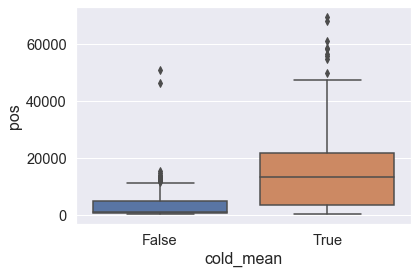

In [32]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

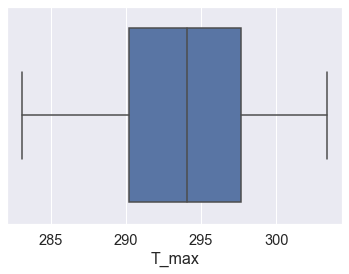

In [33]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [34]:
df_feat_fr["T_max"].median()

294.05877192982456

In [35]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

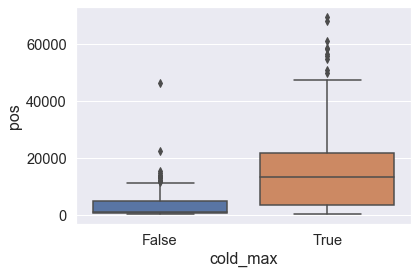

In [36]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [37]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

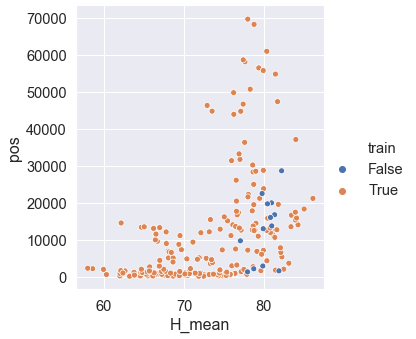

In [38]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

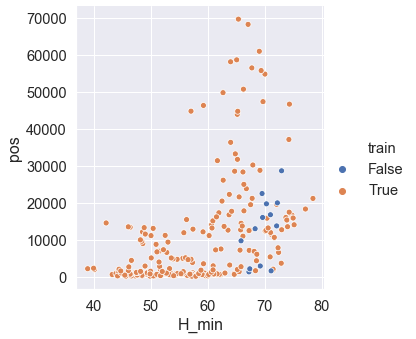

In [39]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

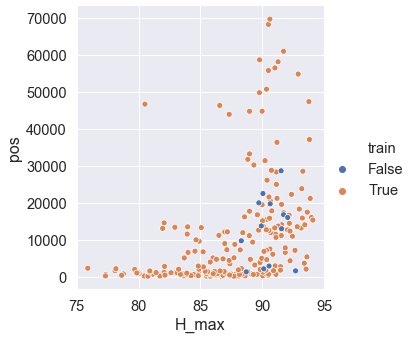

In [40]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

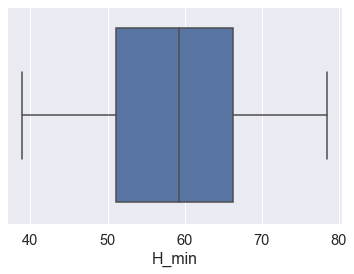

In [41]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [42]:
df_feat_fr["H_min"].median()

59.25862068965517

In [43]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

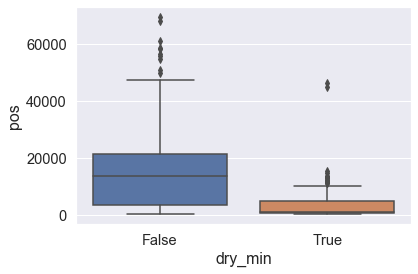

In [44]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

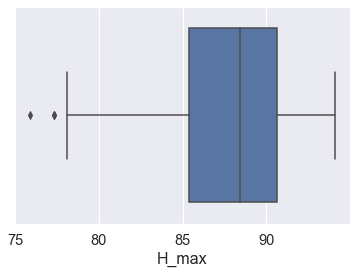

In [45]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [46]:
df_feat_fr["H_max"].median()

88.42372881355931

In [47]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

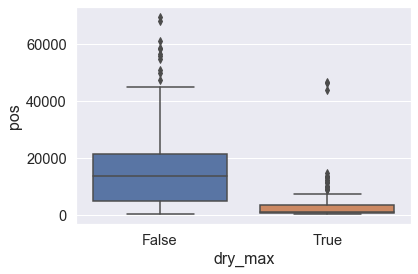

In [48]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

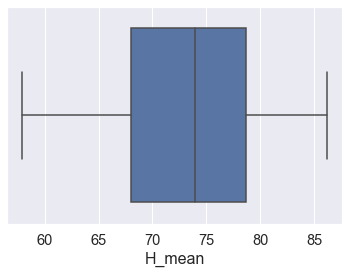

In [49]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [50]:
df_feat_fr["H_mean"].median()

73.98305084745763

In [51]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

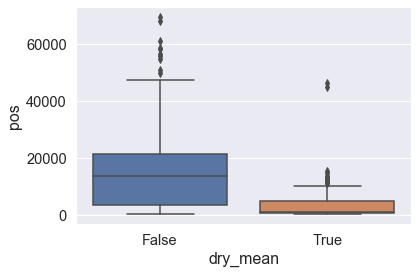

In [52]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [53]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

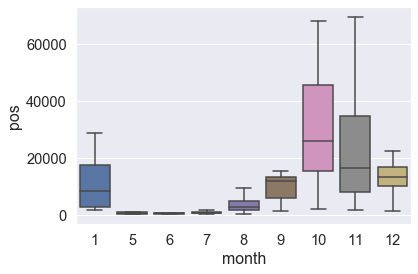

In [54]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

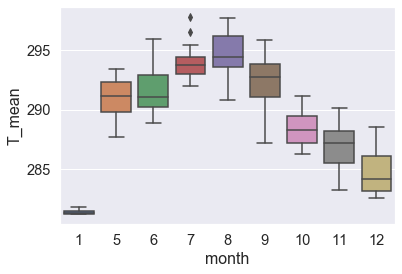

In [55]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

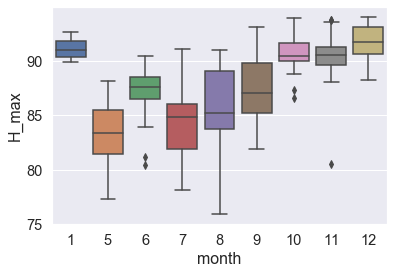

In [56]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [57]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1       46813
5       11838
6       14892
7       24757
8      105823
9      293328
10     932516
11     670573
12     395238

### Nb Tested

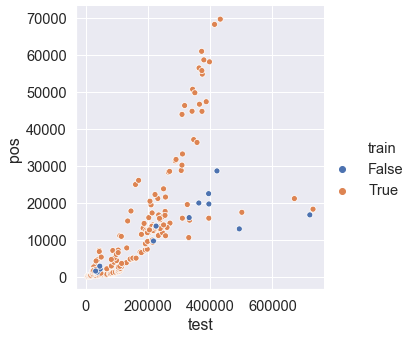

In [58]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [59]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [60]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

### Rt

In [66]:
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  ...  train      T_mean  \
date                                             ...                      
2020-05-13    881  61.023837   39034  55.429856  ...   True  287.715833   
2020-05-14    979  60.426966   41971  54.826499  ...   True  288.006667   
2020-05-15   1021  60.042116   47665  54.380069  ...   True  288.614167   
2020-05-16    291  60.158076   16523  54.488471  ...   True  289.228333   
2020-05-17    139  61.568345    6603  58.292443  ...   True  290.022500   
...           ...        ...     ...        ...  ...    ...         ...   
2020-12-31  16015  48.586263  332662  47.453568  ...  False  282.559322   
2021-01-01   1562  55.415493   32334  51.218346  ...  False  281.764167   
2021-01-02  13727  46.572886  226475  48.801766  ...  False  281.305833   
2021-01-03   2876  51.449930   45631  50.162587  ...  False  281.158475   
2021-01-04  28648  48.073792  421912  50.712843  ...  False  281.178333   

            cold_min  cold_mean  cold_max     H_mean  dry_min  dry_max  \
date                                                                     
2020-05-13      True       True      True  76.398305    False     True   
2020-05-14      True       True      True  72.127119    False     True   
2020-05-15      True       True      True  70.169492     True     True   
2020-05-16      True       True      True  70.137931     True     True   
2020-05-17      True       True     False  67.689655     True     True   
...              ...        ...       ...        ...      ...      ...   
2020-12-31      True       True      True  80.830508    False    False   
2021-01-01      True       True      True  81.891667    False    False   
2021-01-02      True       True      True  80.991667    False    False   
2021-01-03      True       True      True  79.872881    False    False   
2021-01-04      True       True      True  82.225000    False    False   

            dry_mean  month  
date                         
2020-05-13     False      5  
2020-05-14      True      5  
2020-05-15      True      5  
2020-05-16      True      5  
2020-05-17      True      5  
...              ...    ...  
2020-12-31     False     12  
2021-01-01     False      1  
2021-01-02     False      1  
2021-01-03     False      1  
2021-01-04     False      1  

[237 rows x 25 columns]

In [68]:
# Create figure 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_feat_fr["date"], 
                         y=df_feat_fr["Rt"],
                    mode='lines+markers',
                    line_shape='linear',
                    name="Rt"))
fig.update_layout(title='COVID-19 Reproduction number Rt (France)',
                 yaxis_title='Rt [-]')
fig.show()

## Prepare features

In [69]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [70]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    881   39034   
2020-05-14  285.050000  290.963333  59.406780  84.847458    979   41971   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   47665   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16523   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6603   
...                ...         ...        ...        ...    ...     ...   
2020-12-31  279.726271  285.392373  69.610169  92.050847  16015  332662   
2021-01-01  279.578333  283.950000  71.100000  92.683333   1562   32334   
2021-01-02  279.173333  283.438333  72.066667  89.916667  13727  226475   
2021-01-03  279.226271  283.090678  69.203390  90.542373   2876   45631   
2021-01-04  279.273333  283.083333  72.933333  91.516667  28648  421912   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.023837  55.429856  
2020-05-14        4  60.426966  54.826499  
2020-05-15        5  60.042116  54.380069  
2020-05-16        6  60.158076  54.488471  
2020-05-17        0  61.568345  58.292443  
...             ...        ...        ...  
2020-12-31        4  48.586263  47.453568  
2021-01-01        5  55.415493  51.218346  
2021-01-02        6  46.572886  48.801766  
2021-01-03        0  51.449930  50.162587  
2021-01-04        1  48.073792  50.712843  

[237 rows x 9 columns]

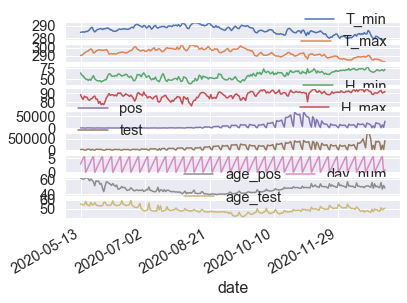

In [71]:
features.plot(subplots=True);

In [72]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [73]:
dataset.shape

(237, 9)

## Multi-step model

### Helper functions

In [74]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [75]:
TRAIN_SPLIT

223

In [76]:
dataset.shape

(237, 9)

In [77]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [78]:
y_train_multi.shape

(209, 7)

In [79]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

209 Single window of past history : (14, 9)

 209 Target temperature to predict : (7,)


In [80]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 209
BUFFER_SIZE : 223

For validation : 
BATCH_SIZE_VAL : 7


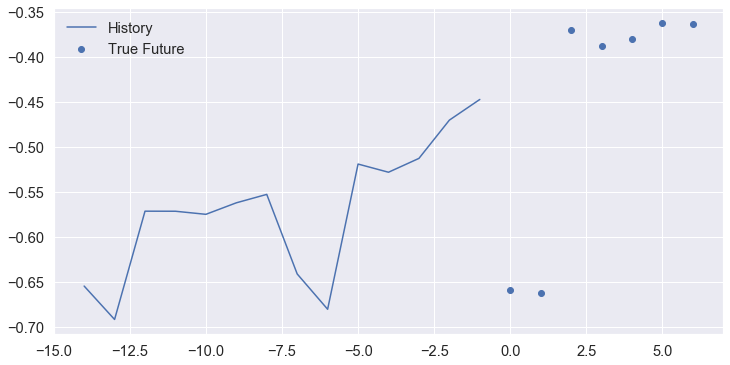

In [81]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [82]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 209
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00792: early stopping
Run #0 : val_loss = 0.4204314053058624


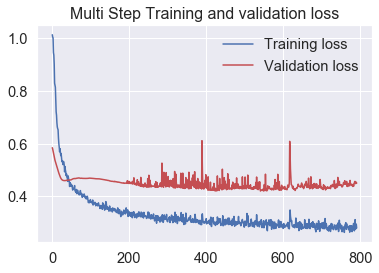

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00497: early stopping
Run #1 : val_loss = 0.4733695685863495

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping
Run #2 : val_loss = 0.5207135081291199

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00893: early stopping
Run #3 : val_loss = 0.3746677041053772


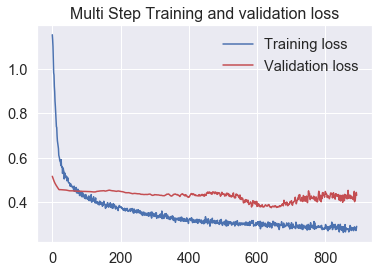

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00513: early stopping
Run #4 : val_loss = 0.4256780743598938

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00269: early stopping
Run #5 : val_loss = 0.4825190007686615

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00432: early stopping
Run #6 : val_loss = 0.48651033639907837

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00844: early stopping
Run #7 : val_loss = 0.4046885669231415

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00278: early stopping
Run #8 : val_loss = 0.4691297709941864

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00319: early stopping
Run #9 : val_loss = 0.4797144830226898

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 00674: early stopping
Run #10 : val_loss = 0.451863557100296

 Run #1

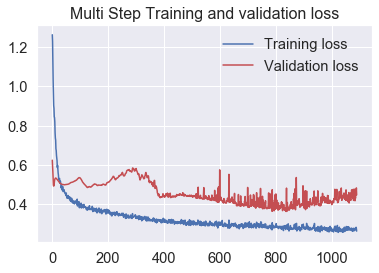

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #19
Restoring model weights from the end of the best epoch.
Epoch 00303: early stopping
Run #19 : val_loss = 0.45492833852767944

 Run #20
Restoring model weights from the end of the best epoch.
Epoch 00642: early stopping
Run #20 : val_loss = 0.42377784848213196

 Run #21
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
Run #21 : val_loss = 0.43947234749794006

 Run #22
Restoring model weights from the end of the best epoch.
Epoch 00391: early stopping
Run #22 : val_loss = 0.4999942481517792

 Run #23
Restoring model weights from the end of the best epoch.
Epoch 00292: early stopping
Run #23 : val_loss = 0.44759368896484375

 Run #24
Restoring model weights from the end of the best epoch.
Epoch 00411: early stopping
Run #24 : val_loss = 0.4494902193546295

 Run #25
Restoring model weights from the end of the best epoch.
Epoch 00324: early stopping
Run #25 : val_loss = 0.486562877

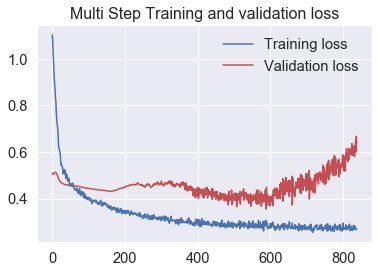

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #59
Restoring model weights from the end of the best epoch.
Epoch 00997: early stopping
Run #59 : val_loss = 0.4256664216518402

 Run #60
Restoring model weights from the end of the best epoch.
Epoch 00266: early stopping
Run #60 : val_loss = 0.4612697660923004

 Run #61
Restoring model weights from the end of the best epoch.
Epoch 00596: early stopping
Run #61 : val_loss = 0.45899131894111633

 Run #62
Restoring model weights from the end of the best epoch.
Epoch 00570: early stopping
Run #62 : val_loss = 0.4718221127986908

 Run #63
Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping
Run #63 : val_loss = 0.4806966781616211

 Run #64
Restoring model weights from the end of the best epoch.
Epoch 00724: early stopping
Run #64 : val_loss = 0.43063071370124817

 Run #65
Restoring model weights from the end of the best epoch.
Epoch 00504: early stopping
Run #65 : val_loss = 0.48195987939

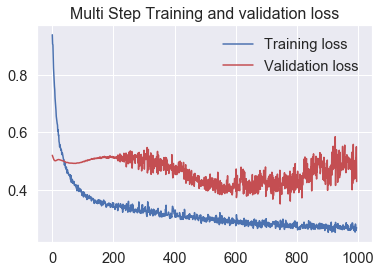

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #91
Restoring model weights from the end of the best epoch.
Epoch 00572: early stopping
Run #91 : val_loss = 0.4518778622150421

 Run #92
Restoring model weights from the end of the best epoch.
Epoch 00925: early stopping
Run #92 : val_loss = 0.40092307329177856

 Run #93
Restoring model weights from the end of the best epoch.
Epoch 00445: early stopping
Run #93 : val_loss = 0.4895792007446289

 Run #94
Restoring model weights from the end of the best epoch.
Epoch 00401: early stopping
Run #94 : val_loss = 0.45898833870887756

 Run #95
Restoring model weights from the end of the best epoch.
Epoch 00504: early stopping
Run #95 : val_loss = 0.40710482001304626

 Run #96
Restoring model weights from the end of the best epoch.
Epoch 01189: early stopping
Run #96 : val_loss = 0.38675007224082947

 Run #97
Restoring model weights from the end of the best epoch.
Epoch 00623: early stopping
Run #97 : val_loss = 0.390056133

Restoring model weights from the end of the best epoch.
Epoch 01469: early stopping
Run #151 : val_loss = 0.34513479471206665


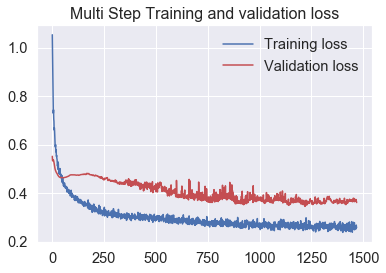

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #152
Restoring model weights from the end of the best epoch.
Epoch 00347: early stopping
Run #152 : val_loss = 0.4376506209373474

 Run #153
Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping
Run #153 : val_loss = 0.46588414907455444

 Run #154
Restoring model weights from the end of the best epoch.
Epoch 00318: early stopping
Run #154 : val_loss = 0.5077071189880371

 Run #155
Restoring model weights from the end of the best epoch.
Epoch 00336: early stopping
Run #155 : val_loss = 0.49214881658554077

 Run #156
Restoring model weights from the end of the best epoch.
Epoch 00634: early stopping
Run #156 : val_loss = 0.4151293933391571

 Run #157
Restoring model weights from the end of the best epoch.
Epoch 01112: early stopping
Run #157 : val_loss = 0.39041581749916077

 Run #158
Restoring model weights from the end of the best epoch.
Epoch 01016: early stopping
Run #158 : val_loss 

Restoring model weights from the end of the best epoch.
Epoch 00275: early stopping
Run #212 : val_loss = 0.49258941411972046

 Run #213
Restoring model weights from the end of the best epoch.
Epoch 00784: early stopping
Run #213 : val_loss = 0.3820917308330536

 Run #214
Restoring model weights from the end of the best epoch.
Epoch 00746: early stopping
Run #214 : val_loss = 0.4053857624530792

 Run #215
Restoring model weights from the end of the best epoch.
Epoch 00358: early stopping
Run #215 : val_loss = 0.5065509676933289

 Run #216
Restoring model weights from the end of the best epoch.
Epoch 00508: early stopping
Run #216 : val_loss = 0.4840990900993347

 Run #217
Restoring model weights from the end of the best epoch.
Epoch 01105: early stopping
Run #217 : val_loss = 0.36998483538627625

 Run #218
Restoring model weights from the end of the best epoch.
Epoch 00797: early stopping
Run #218 : val_loss = 0.3984280228614807

 Run #219
Restoring model weights from the end of the be

Restoring model weights from the end of the best epoch.
Epoch 00304: early stopping
Run #273 : val_loss = 0.4703369140625

 Run #274
Restoring model weights from the end of the best epoch.
Epoch 01174: early stopping
Run #274 : val_loss = 0.4332662522792816

 Run #275
Restoring model weights from the end of the best epoch.
Epoch 00278: early stopping
Run #275 : val_loss = 0.42524465918540955

 Run #276
Restoring model weights from the end of the best epoch.
Epoch 00269: early stopping
Run #276 : val_loss = 0.48237642645835876

 Run #277
Restoring model weights from the end of the best epoch.
Epoch 00314: early stopping
Run #277 : val_loss = 0.4540896415710449

 Run #278
Restoring model weights from the end of the best epoch.
Epoch 00305: early stopping
Run #278 : val_loss = 0.48174744844436646

 Run #279
Restoring model weights from the end of the best epoch.
Epoch 00355: early stopping
Run #279 : val_loss = 0.44421228766441345

 Run #280
Restoring model weights from the end of the bes

Restoring model weights from the end of the best epoch.
Epoch 00342: early stopping
Run #334 : val_loss = 0.4420332610607147

 Run #335
Restoring model weights from the end of the best epoch.
Epoch 00264: early stopping
Run #335 : val_loss = 0.48753800988197327

 Run #336
Restoring model weights from the end of the best epoch.
Epoch 00596: early stopping
Run #336 : val_loss = 0.45422491431236267

 Run #337
Restoring model weights from the end of the best epoch.
Epoch 00390: early stopping
Run #337 : val_loss = 0.41334930062294006

 Run #338
Restoring model weights from the end of the best epoch.
Epoch 00297: early stopping
Run #338 : val_loss = 0.49891453981399536

 Run #339
Restoring model weights from the end of the best epoch.
Epoch 00470: early stopping
Run #339 : val_loss = 0.4712340831756592

 Run #340
Restoring model weights from the end of the best epoch.
Epoch 00370: early stopping
Run #340 : val_loss = 0.49506136775016785

 Run #341
Restoring model weights from the end of the

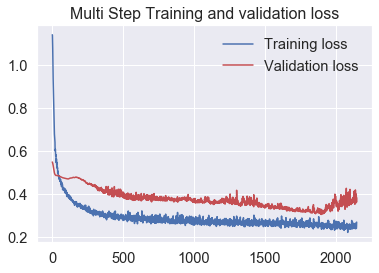

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #384
Restoring model weights from the end of the best epoch.
Epoch 00315: early stopping
Run #384 : val_loss = 0.4774920642375946

 Run #385
Restoring model weights from the end of the best epoch.
Epoch 01121: early stopping
Run #385 : val_loss = 0.4057765007019043

 Run #386
Restoring model weights from the end of the best epoch.
Epoch 01170: early stopping
Run #386 : val_loss = 0.4047989845275879

 Run #387
Restoring model weights from the end of the best epoch.
Epoch 00823: early stopping
Run #387 : val_loss = 0.40027207136154175

 Run #388
Restoring model weights from the end of the best epoch.
Epoch 00480: early stopping
Run #388 : val_loss = 0.45631346106529236

 Run #389
Restoring model weights from the end of the best epoch.
Epoch 00670: early stopping
Run #389 : val_loss = 0.4416048228740692

 Run #390
Restoring model weights from the end of the best epoch.
Epoch 00436: early stopping
Run #390 : val_loss =

Restoring model weights from the end of the best epoch.
Epoch 00278: early stopping
Run #444 : val_loss = 0.4495790898799896

 Run #445
Restoring model weights from the end of the best epoch.
Epoch 00336: early stopping
Run #445 : val_loss = 0.47155413031578064

 Run #446
Restoring model weights from the end of the best epoch.
Epoch 00415: early stopping
Run #446 : val_loss = 0.4732350707054138

 Run #447
Restoring model weights from the end of the best epoch.
Epoch 00354: early stopping
Run #447 : val_loss = 0.46052536368370056

 Run #448
Restoring model weights from the end of the best epoch.
Epoch 00685: early stopping
Run #448 : val_loss = 0.44485968351364136

 Run #449
Restoring model weights from the end of the best epoch.
Epoch 00822: early stopping
Run #449 : val_loss = 0.38839191198349

 Run #450
Restoring model weights from the end of the best epoch.
Epoch 00593: early stopping
Run #450 : val_loss = 0.42125388979911804

 Run #451
Restoring model weights from the end of the be

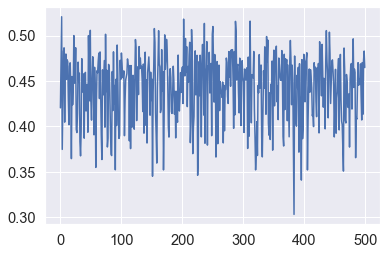

In [87]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 500
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2 : err=1.23 mais diverge
    # lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
    # lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
    # lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
    # lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
    # lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
    # lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
    # lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
    # lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
    # Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
    # Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
    # Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
    # 2021-01-08 : 2min 10epochs 5000people patience 250
    # 2021-01-08 : Final val_loss = 0.3031 Mean asbolute Error in people : 4429 Wall time: 1h 26min 5s
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


### Eval

In [88]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

Wall time: 1.97 s


In [89]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  4429.5618374952155
Mean nb cases  [nb of cases]:  12895.795918367347
mean relative error [%]:  34.34888288815301


In [90]:
multi_step_model.predict(x_val_multi)

array([[ 0.67773044,  0.6420115 ,  0.1853933 , -0.24094845, -0.64560807,
        -0.44303134,  0.5228845 ],
       [ 0.42179018,  0.23063402, -0.13653362, -0.18612497,  0.06828996,
         0.3630044 ,  0.5827227 ],
       [ 0.15161078,  0.04762296, -0.04048109,  0.05839257,  0.4729482 ,
         0.7143838 ,  0.53446674],
       [-0.05036067,  0.00632278,  0.34110987,  0.45572206,  0.7300778 ,
         0.84977007,  0.4742034 ],
       [ 0.04517705,  0.02686704,  0.3419152 ,  0.44421083,  0.53613424,
         0.43245685,  0.12553045],
       [-0.41035926, -0.19105624,  0.62605804,  0.7124249 ,  0.5556193 ,
         0.36400697, -0.04398012],
       [ 0.72534496,  0.60727215,  0.63942367,  0.71009713,  0.63398606,
         0.05239324, -0.23597416]], dtype=float32)

In [91]:
y_val_multi_pred.shape[0]

7

In [92]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

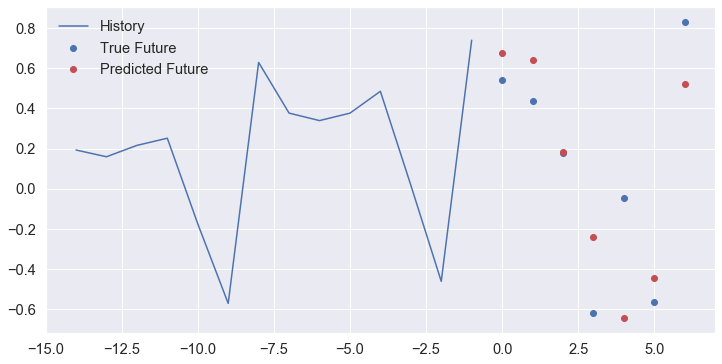

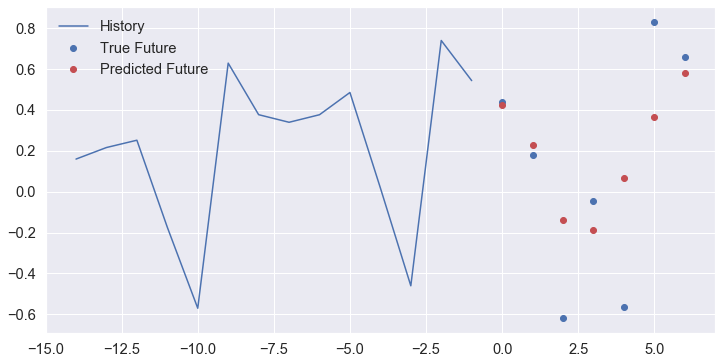

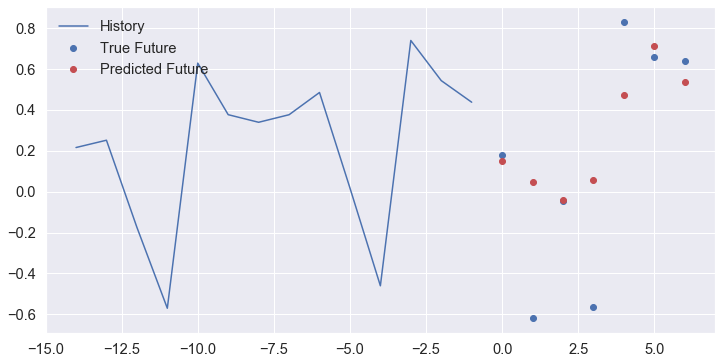

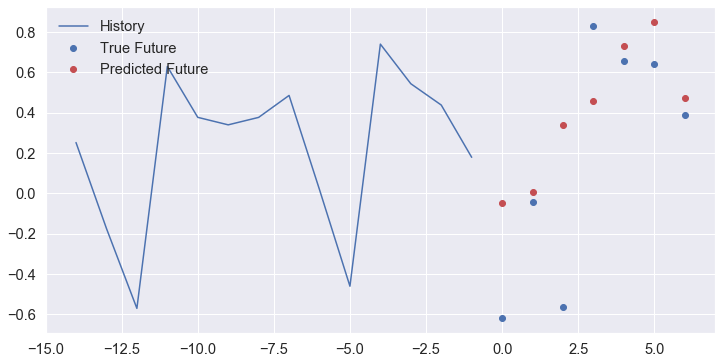

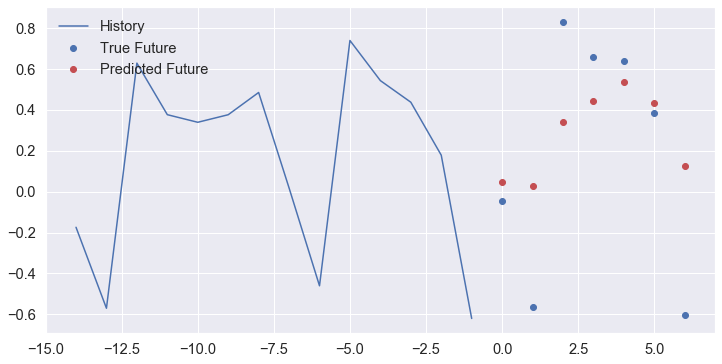

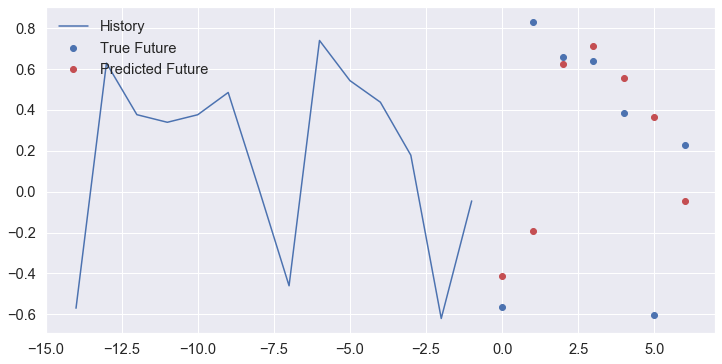

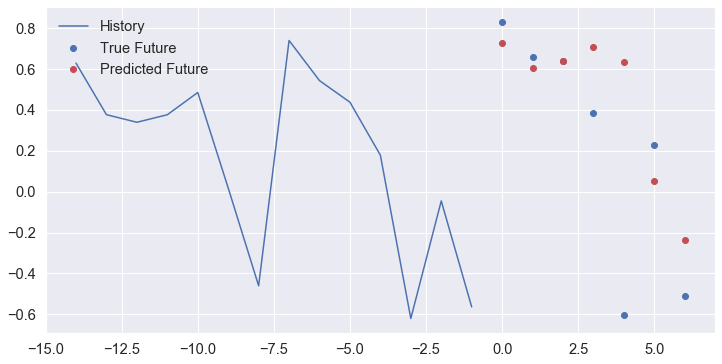

In [93]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [94]:
nb_period_plot = 9 #23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [95]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [96]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [97]:
TRAIN_SPLIT

223

In [98]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [99]:
df_feat_fr.shape

(237, 15)

In [100]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


Wall time: 108 ms


In [101]:
df_feat_fr.date.min()

'2020-05-13'

In [102]:
df_feat_fr.date.max()

'2021-01-04'

In [103]:
df_feat_fr.pos.std()

14367.992865929022

In [104]:
data_std[4]

14614.170648746674

In [105]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-11-02'

In [106]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2021-01-05  2021-01-05  22045   2658050
2021-01-06  2021-01-06  20394   2678444
2021-01-07  2021-01-07  17513   2695957
2021-01-08  2021-01-08  12690   2708647
2021-01-09  2021-01-09   7252   2715899
2021-01-10  2021-01-10   9594   2725493
2021-01-11  2021-01-11  21572   2747065

In [107]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-12-22'

In [108]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-11-02  286.608333  2020-11-02  293.685000  65.372881  90.610169     0.0   
2020-11-03  284.415000  2020-11-03  289.858333  65.067797  89.779661     0.0   
2020-11-04  282.220000  2020-11-04  288.680000  62.677966  89.762712     0.0   
2020-11-05  284.858475  2020-11-05  286.180508  74.310345  80.517241     0.0   
2020-11-06  283.250000  2020-11-06  291.140000  65.254237  88.966102     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-11-02  69707  48.218787  432656  49.171540        1   1599926   630385.0   
2020-11-03  58684  49.055841  379828  49.502172        2   1658610   645129.0   
2020-11-04  49798  48.615487  350924  48.526698        3   1708408   648587.0   
2020-11-05  46694  48.561614  365713  48.947347        4   1755102   644538.0   
2020-11-06  44764  48.574547  373819  48.972749        5   1799866   634471.0   
...           ...        ...     ...        ...      ...       ...        ...   
2020-12-31  16015  48.586263  332662  47.453568        4   2589192   192170.0   
2021-01-01   1562  55.415493   32334  51.218346        5   2590754   176281.0   
2021-01-02  13727  46.572886  226475  48.801766        6   2604481   179385.0   
2021-01-03   2876  51.449930   45631  50.162587        0   2607357   178636.0   
2021-01-04  28648  48.073792  421912  50.712843        1   2636005   186114.0   

                  Rt   rate_pos  
date                             
2020-11-02  1.982499  16.111414  
2020-11-03  1.883891  15.450151  
2020-11-04  1.760895  14.190537  
2020-11-05  1.624323  12.767936  
2020-11-06  1.482994  11.974779  
...              ...        ...  
2020-12-31  1.148683   4.814196  
2021-01-01  1.023533   4.830828  
2021-01-02  1.017504   6.061155  
2021-01-03  1.002610   6.302733  
2021-01-04  1.018619   6.790042  

[64 rows x 15 columns]

### Figure

In [109]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [110]:
nb_period_plot

9

In [111]:
19*7

133

In [112]:
179-4*7

151

In [113]:
dataset.shape

(237, 9)

In [114]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[160 - 174]
[167 - 181]
[174 - 188]
[181 - 195]
[188 - 202]
[195 - 209]
[202 - 216]
[209 - 223]
[216 - 230]
9
Wall time: 229 ms


array([[48774.977  , 48387.04   , 40821.438  , 27992.305  , 12843.855  ,
        10868.529  , 34764.18   , 33760.99   , 33141.227  , 27341.582  ,
        18373.748  ,  7751.032  ,  6830.9785 , 23531.564  , 19770.203  ,
        18980.756  , 15548.846  , 10960.391  ,  5768.2344 ,  5715.2515 ,
        14484.892  , 12793.737  , 12350.097  , 10456.022  ,  8089.127  ,
         5889.611  ,  6011.134  , 10196.097  , 12056.085  , 11511.451  ,
         9788.355  ,  7339.396  ,  5025.6494 ,  5832.9062 , 10988.545  ,
        13247.569  , 12426.342  , 10832.239  ,  8438.342  ,  5974.1587 ,
         6879.168  , 12358.41   , 16208.101  , 15215.77   , 12103.838  ,
         8854.376  ,  6047.7095 ,  7148.129  , 13890.697  , 20261.703  ,
        19739.703  , 13066.605  ,  6835.9756 ,   922.20996,  3882.7026 ,
        17998.76   , 21422.441  , 20446.512  , 19690.768  , 15778.641  ,
        11032.603  , 12902.53   , 23091.342  ]], dtype=float32)

In [115]:
y_pos_pred.shape

(1, 63)

In [116]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-11-02
2021-01-04


date    pos  nb_cases
2020-11-03  2020-11-03  48774   1648700
2020-11-04  2020-11-04  48387   1697087
2020-11-05  2020-11-05  40821   1737908
2020-11-06  2020-11-06  27992   1765900
2020-11-07  2020-11-07  12843   1778743
...                ...    ...       ...
2020-12-31  2020-12-31  19690   2595062
2021-01-01  2021-01-01  15778   2610840
2021-01-02  2021-01-02  11032   2621872
2021-01-03  2021-01-03  12902   2634774
2021-01-04  2021-01-04  23091   2657865

[63 rows x 3 columns]

### Figure all past 

In [117]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [118]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [119]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()